# Code

## 1: Spotify API
This part takes care of the contact with Spotifys web API, both authorization and searches.

In [1]:
# Libraries
import base64
import datetime
import requests
from urllib.parse import urlencode

In [2]:
class SpotifyAPI(object):
    access_token = None
    access_token_expires = datetime.datetime.now()
    access_token_did_expire = True
    client_id = None
    client_secret = None
    token_url = "https://accounts.spotify.com/api/token"
    
    def __init__(self, client_id, client_secret,*args,**kwargs):
        super().__init__(*args,**kwargs)
        self.client_id = client_id
        self.client_secret = client_secret   
        
    def get_client_credentials(self):
        """
        Returns a base64 encoded string
        """
        client_id = self.client_id
        client_secret = self.client_secret
        if client_secret == None or client_id == None:
            raise Exception("You must set client_id and client_secret")
        client_creds = f"{client_id}:{client_secret}"
        client_creds_b64 = base64.b64encode(client_creds.encode())

        return client_creds_b64.decode()
        
    def get_token_headers(self):
        client_creds_b64 = self.get_client_credentials()
        
        return{
                "Authorization" : f"Basic {client_creds_b64}"            
                }

    def get_token_data(self):
        return{
               "grant_type" : "client_credentials" 
               }
        
    def perform_auth(self):     
        token_url = self.token_url
        token_data = self.get_token_data()
        token_headers = self.get_token_headers()
        r = requests.post(token_url, data=token_data, headers = token_headers)
         
        if r.status_code not in range(200,299):
             raise Exception("Could not authenticate client.")
        
        data = r.json()
        now = datetime.datetime.now()
        access_token = data["access_token"]
        expires_in = data["expires_in"]
        expires = now + datetime.timedelta(seconds=expires_in)
        self.access_token = access_token
        self.access_token_expires = expires
        self.access_token_did_expire = expires < now
        return True   
    
    def get_access_token(self):
        token = self.access_token
        expires = self.access_token_expires
        now = datetime.datetime.now()
        if expires < now:
            self.perform_auth()
            return self.get_access_token()
        elif token == None:
            self.perform_auth()
            return self.get_access_token()
        return token
    
    def get_resource_header(self):
        access_token = self.get_access_token()
        headers = {
            "Authorization": f"Bearer {access_token}"
            }
        return headers
    
    def get_resource(self, lookup_id, resource_type="albums", version="v1"):
        endpoint = f"https://api.spotify.com/{version}/{resource_type}/{lookup_id}"
        headers = self.get_resource_header()
        r = requests.get(endpoint, headers=headers)
        if r.status_code not in range(200, 299):
            return {}
        return r.json()
    
    def get_album(self, _id):
        return self.get_resource(_id, resource_type="albums") 

    def get_artist(self, _id):
        return self.get_resource(_id, resource_type="artists") 

    def get_audio_features(self, _id):
        return self.get_resource(_id, resource_type="audio-features") 

    def get_track(self, _id):
        return self.get_resource(_id, resource_type="track") 
  
    def get_related_artists(self, lookup_id, resource_type="artists", version="v1"):
        endpoint = f"https://api.spotify.com/{version}/{resource_type}/{lookup_id}/related-artists"
        headers = self.get_resource_header()
        r = requests.get(endpoint, headers=headers)
        if r.status_code not in range(200, 299):
            return {}
        return r.json()
    
    def get_artist_top_tracks(self, lookup_id, resource_type="artists", version="v1"):
        endpoint = f"https://api.spotify.com/{version}/{resource_type}/{lookup_id}/top-tracks?country=se"
        headers = self.get_resource_header()
        r = requests.get(endpoint, headers=headers)
        if r.status_code not in range(200, 299):
            return {}
        return r.json()
    
    def base_search(self, query_params):
        headers = self.get_resource_header()
        endpoint = "https://api.spotify.com/v1/search"
        lookup_url = f"{endpoint}?{query_params}"
        r = requests.get(lookup_url, headers=headers)
        if r.status_code not in range(200,299):
            return {}
        return r.json()

    def search(self, query=None, operator = None, operator_query=None, search_type="artist"):
        if query==None:
            raise Exception("A query is required.")
        if isinstance(query, dict):
                   # letar genom alla key-value-par i dict och gör dem till str
            query = " ".join([f"{k}:{v}" for k,v in query.items()])
            
        if operator != None and operator_query != None:
            if operator == "or" or operator == "not":
                operator = operator.upper()
                if isinstance(operator_query,str):
                    query = f"{query} {operator} {operator_query}"
                
        query_params  = urlencode({"q": query, "type": search_type.lower()})
        #print(query_params)
 
        return self.base_search(query_params)


## 2: Functions
Functions used for creating dataframes of the information gathered from searches.

In [111]:
def related_artists_10(related_artists):
    related = []
    for k in range(10):    
        artist = {"Namn" : related_artists["artists"][k]["name"],
              "Genre": related_artists["artists"][k]["genres"],
              "Popularity":related_artists["artists"][k]["popularity"],
              "Id":related_artists["artists"][k]["id"],
              "Top_Songs": top_tracks(related_artists["artists"][k]["id"])
            }
        related.append(artist)
    return related 

def top_tracks(_id):
    rek1 = spotify.get_artist_top_tracks(_id)
    dvs = pd.DataFrame(columns={"Name","Popularity","Id",
                                "acousticness", "danceability","duration_ms", "energy",
                                "instrumentalness", "key", "liveness", "loudness", "mode", 
                                "speechiness","tempo","time_signature","valence"
                                }, index = range(len(rek1["tracks"])))
    for k in range(len(rek1["tracks"])):
        dvs["Name"][k] = rek1["tracks"][k]["name"]
        dvs["Popularity"][k] = rek1["tracks"][k]["popularity"]
        dvs["Id"][k] = rek1["tracks"][k]["id"]
        audio_features = spotify.get_audio_features(dvs["Id"][k])
        dvs["acousticness"][k] = audio_features["acousticness"]
        dvs["danceability"][k] = audio_features["danceability"]
        dvs["duration_ms"][k] = audio_features["duration_ms"]
        dvs["energy"][k] = audio_features["energy"]
        dvs["instrumentalness"][k] = audio_features["instrumentalness"]
        dvs["key"][k] = audio_features["key"]
        dvs["liveness"][k] = audio_features["liveness"]
        dvs["loudness"][k] = audio_features["loudness"]
        dvs["mode"][k] = audio_features["mode"]
        dvs["speechiness"][k] = audio_features["speechiness"]
        dvs["tempo"][k] = audio_features["tempo"]
        dvs["time_signature"][k] = audio_features["time_signature"]
        dvs["valence"][k] = audio_features["valence"]
        columns_order = ["Name","Id","Popularity",
                "acousticness", "danceability","duration_ms", "energy",
                "instrumentalness", "key", "liveness", "loudness", "mode", 
                "speechiness","tempo","time_signature","valence"]
        dvs=dvs.reindex(columns=columns_order)

    return dvs

def artist_id(song_name,artist_name):
    _id = spotify.search({"track": song_name,"artist": artist_name},
                           search_type ="track")["tracks"]["items"][0]["artists"][0]["id"]
    artist = [artist_name]
    artist.append(_id)
    
    return artist
    
def data_from_spotify(mest_lyssnade):  
    sample_list = []

    for k in range(len(mest_lyssnade)):
        start_artist = []
        related_artists = spotify.get_related_artists(mest_lyssnade.iloc[k,2])
        start_artist = related_artists_10(related_artists)
        sample_list.append(start_artist)


    sample = pd.DataFrame(columns=sample_list[0][0]["Top_Songs"].columns, index = range(1000))
    sample["Artist"] = np.nan
    sample["Genre"] = np.nan
    sample["Artist_Popularity"] = np.nan
   
    n = 0
    m = 0
    for i in range(len(sample_list)):
        n = 100 * i
        for k in range(10):
            m = 10 * k
            for j in range(10): 
                if j < len(sample_list[i][k]["Top_Songs"]):
                    sample.iloc[n+m+j] = sample_list[i][k]["Top_Songs"].iloc[j]
                    sample["Artist"][n+m+j] = sample_list[i][k]["Namn"]
                    sample["Genre"][n+m+j] = sample_list[i][k]["Genre"]
                    sample["Artist_Popularity"][n+m+j] = sample_list[i][k]["Popularity"]
        m = 0 
    sample = sample.dropna(subset=["Id"])
    sample = sample.reset_index(drop=True)
    
    return sample

def genres(potential_songs, listened_features, most_listened_songs):
    columns_order = ["Genre","Potential","Listened","Top"]
    potential_songs = potential_songs.reset_index(drop=True)
    listened_features = listened_features.reset_index(drop=True)
    most_listened_songs = most_listened_songs.reset_index(drop=True)
    
    genre_sum1 = pd.DataFrame(np.sum(potential_songs.Genre))[0].value_counts()
    genre_sum2 = pd.DataFrame(np.sum(listened_features.Genre))[0].value_counts()
    genre_sum3 = pd.DataFrame(np.sum(most_listened_songs.Genre))[0].value_counts()

    genre_sum = pd.DataFrame(columns={"Genre","Potential","Listened","Top"})
    genre_sum["Genre"] = genre_sum1.index
    genre_sum["Potential"] = genre_sum1.values
    for k in range(len(genre_sum2)):
        if genre_sum2.index[k] in genre_sum.Genre.values:
            contains = pd.DataFrame(genre_sum[genre_sum["Genre"].str.contains(genre_sum2.index[k], na=False)]["Genre"])
            contains["orig_ix"] = contains.index
            contains = contains.reset_index(drop=True)
            for i in range(len(contains)):
                if contains["Genre"][i] == genre_sum2.index[k]:
                    genre_sum["Listened"][contains["orig_ix"][i]] = genre_sum2[k]
                    break
        else: 
            append = pd.DataFrame(columns={"Genre","Potential","Listened","Top"}, index = range(1))
            append.iloc[0] = genre_sum2.index[k], genre_sum2[k], 0, 0
            genre_sum = genre_sum.append(append)
    genre_sum = genre_sum.reset_index(drop=True)
    genre_sum = genre_sum.reindex(columns=columns_order)

            
           
    for k in range(len(genre_sum3)):
        contains = pd.DataFrame(genre_sum[genre_sum["Genre"].str.contains(genre_sum3.index[k], na=False)]["Genre"])
        contains["orig_ix"] = contains.index
        contains = contains.reset_index(drop=True)
        for i in range(len(contains)):
            if contains["Genre"][i] == genre_sum3.index[k]:
                genre_sum["Top"][contains["orig_ix"][i]] = genre_sum3[k]
                break
    
      
    genre_sum = genre_sum.replace(np.nan,0)     

        
    return genre_sum


def print_confusion_matrix(confusion_matrix, class_names, fontsize=16):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=(6,5))
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d",linewidths=.5, center=0)
        
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    heatmap.set_ylim([0,2])
    plt.ylabel("Actual label")
    plt.xlabel("Predicted label")
    
    return fig


## 3: Song Discoverer

In [4]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")

import warnings
warnings.filterwarnings('ignore')

client_id = "spotify_client_id"
client_secret = "spotify_client_secret"
spotify = SpotifyAPI(client_id, client_secret)

/Users/edvardcarlsson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### 3.1: Song Samples

In [8]:
# Import of my entire listening history, since this is the third week I try the Song Discoverer and I only want to base the recomendation on last weeks listens it is important that I seperate them from older listens.
listened = pd.read_csv("listened_week_32.csv")

# The first row of my data gets assigned as columns, this fixes it
listened.loc[-1] = [listened.columns[0], listened.columns[1], listened.columns[2], listened.columns[3]]  # adding a row
listened.index = listened.index + 1  # shifting index
listened.sort_index(inplace=True) 
listened.columns = ["Artist", "Album", "Song","Date"]
listened = listened.reset_index(drop=True)
print("Number of songs from all time listening history: ", len(listened))

Number of songs from all time listening history:  2330


In [22]:
# Since I can see the recording timestamp of my plays I can locate with songs are from this week, I'm making a new dataframe of them.
nbr_of_songs_this_week = 833
listened_last_week = listened[:nbr_of_songs_this_week]

# I'm also saving this data to a new csv file for possible future extensions of the project
listened_last_week.to_csv(r'week_31.csv')

listened_last_week.head()



,Artist,Album,Song,Date
0,ZHU,stardustexhalemarrakechdreams,Dreams,09 Aug 2020 11:51
1,Ekali,Blame,Blame,09 Aug 2020 11:48
2,ZHU,stardustexhalemarrakechdreams,Exhale,09 Aug 2020 11:44
3,ZHU,Nightday (EP),Cocaine Model,09 Aug 2020 11:40
4,ZHU,stardustexhalemarrakechdreams,Chasing Marrakech,09 Aug 2020 11:36


In [23]:
# As my algorithm is based on my top 10 most streamed artist from the last week I create a new dataframe with them
top_artists = pd.DataFrame(listened_last_week.groupby(["Artist"]).count())
top_artists["Artist"] = top_artists.index
top_artists = top_artists.sort_values(by="Date", ascending=False)
top_artists = top_artists.iloc[0:10,2:]
top_artists.columns = ["Plays", "Artist"]
top_artists = top_artists.reset_index(drop=True)

top_artists["id"] = np.nan
for k in range(len(top_artists)):
    top_artists["id"][k] = spotify.search({"artist": top_artists.iloc[k,1]}, search_type ="artist")["artists"]["items"][0]["id"]
top_artists

,Plays,Artist,id
0,145,Cheat Codes,7DMveApC7UnC2NPfPvlHSU
1,128,ZHU,28j8lBWDdDSHSSt5oPlsX2
2,38,Robin Schulz,3t5xRXzsuZmMDkQzgOX35S
3,32,CamelPhat,240wlM8vDrf6S4zCyzGj2W
4,25,Lost Frequencies,7f5Zgnp2spUuuzKplmRkt7
5,22,Brooks,0XKOBt59crntr7HQXXO8Yz
6,20,Martin Jensen,4ehtJnVumNf6xzSCDk8aLB
7,17,Dante Klein,1b4DN8Vj0dnj5cceMFsRYN
8,17,Chico Rose,5OdVywqKqyCWwfE2fZb7IX
9,15,Kasabian,11wRdbnoYqRddKBrpHt4Ue


In [28]:
# Gathering my sample of potential songs
potential_songs = data_from_spotify(top_artists)  
potential_songs.head()

,Name,Id,Popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,Artist,Genre,Artist_Popularity
0,I'm Just Feelin' (Du Du Du),73ThEGwF5i9GrsXXGyZBRa,78,0.179,0.736,164885,0.657,4.29e-06,0,0.118,-7.512,1,0.0668,115.989,4,0.548,Martin Jensen,"[big room, dance pop, danish electronic, edm, ...",77.0
1,Nobody,0Qew3aYvQPGPjfL7gbe6x1,66,0.269,0.673,211040,0.687,0,6,0.181,-5.295,0,0.0623,96.964,4,0.524,Martin Jensen,"[big room, dance pop, danish electronic, edm, ...",77.0
2,Don't Cry For Me (with Jason Derulo),5qNYK53oA91QaIC9u7m0oK,61,0.105,0.69,155769,0.587,0,1,0.102,-6.53,0,0.0466,104.046,4,0.278,Martin Jensen,"[big room, dance pop, danish electronic, edm, ...",77.0
3,Day 'N' Nite - Martin Jensen Edit,0ou367q5bmco9pZNxq80iD,72,0.0611,0.766,166200,0.849,0.0809,11,0.0536,-5.42,0,0.0361,125.033,4,0.589,Martin Jensen,"[big room, dance pop, danish electronic, edm, ...",77.0
4,Solo Dance,3R6dPfF2yBO8mHySW1XDAa,60,0.0485,0.746,174933,0.846,0,9,0.195,-2.432,1,0.048,114.955,4,0.403,Martin Jensen,"[big room, dance pop, danish electronic, edm, ...",77.0


In [25]:
# Gather the song features of "listened_last_week"
listened_features = pd.DataFrame(index = listened_last_week.index, columns=potential_songs.columns)
listened_features["Name"] = listened_last_week["Song"]

for k in range(len(listened_last_week)):
    
    if len(spotify.search({"track": listened_last_week.iloc[k,2],"artist": listened_last_week.iloc[k,0],
                "album":listened_last_week.iloc[k,1]}, 
            search_type ="track")["tracks"]["items"]) == 0: # If the song is not found
        continue
    else:
        track = spotify.search({"track": listened_last_week.iloc[k,2],"artist": listened_last_week.iloc[k,0],
                "album":listened_last_week.iloc[k,1]}, 
                search_type ="track")["tracks"]["items"][0]
    
        listened_features["Id"][k] = track["id"]
        listened_features["Popularity"][k] = track["popularity"]
        
        audio_features = spotify.get_audio_features(track["id"])
        listened_features["acousticness"][k] = audio_features["acousticness"]
        listened_features["danceability"][k] = audio_features["danceability"]
        listened_features["duration_ms"][k] = audio_features["duration_ms"]
        listened_features["energy"][k] = audio_features["energy"]
        listened_features["instrumentalness"][k] = audio_features["instrumentalness"]
        listened_features["key"][k] = audio_features["key"]
        listened_features["liveness"][k] = audio_features["liveness"]
        listened_features["loudness"][k] = audio_features["loudness"]
        listened_features["mode"][k] = audio_features["mode"]
        listened_features["speechiness"][k] = audio_features["speechiness"]
        listened_features["tempo"][k] = audio_features["tempo"]
        listened_features["time_signature"][k] = audio_features["time_signature"]
        listened_features["valence"][k] = audio_features["valence"]
        
        listened_features["Artist"][k] = listened_last_week.iloc[k,0]
        artist_id_ = track["artists"][0]["id"]
        artist_features = spotify.get_artist(artist_id_)
        listened_features["Genre"][k]  = artist_features["genres"]
        listened_features["Artist_Popularity"][k]  = artist_features["popularity"]

# Some songs are not found through my search. I´m dropping these, it's unfortunate but since I still have a quite large sample it will do
listened_features = listened_features.dropna(subset=["Id"])
listened_features = listened_features.reset_index(drop=True)


# Save into this df so we only need to find features of last weeks songs
# we only need id
listened_all_time = pd.read_csv("listened_all_time.csv")
listened_all_time.append(listened_features["Id"])
listened_all_time.to_csv(r'listened_all_time.csv')


listened_features.head()

,Name,Id,Popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,Artist,Genre,Artist_Popularity
0,Dreams,66MGk6BwVMx5O1TJqDAX4Y,54,0.0029,0.521,268044,0.55,0.171,1,0.0955,-6.222,1,0.0709,184.018,4,0.0391,ZHU,"[edm, house]",71
1,Blame,089tprIgsyFSOrZpugamLI,55,0.114,0.624,177152,0.68,6.78e-05,9,0.0614,-7.285,0,0.0421,91.998,4,0.117,Ekali,"[bass trap, brostep, canadian electronic, edm,...",60
2,Exhale,6jKDgvE2pnYWRnj7xZV8zc,49,0.0713,0.751,209767,0.644,0.0807,8,0.0801,-9.235,0,0.124,139.985,4,0.252,ZHU,"[edm, house]",71
3,Chasing Marrakech,50z0HWJg4sqh7H8JHol9jC,49,0.127,0.674,242021,0.705,0.501,5,0.361,-5.335,0,0.0349,153.951,4,0.338,ZHU,"[edm, house]",71
4,Home,3ib6WzOzCgVF2kZsxz9H1v,40,0.302,0.665,209154,0.657,0,9,0.0934,-6.181,1,0.0304,89.995,4,0.332,Jubël,"[swedish pop, tropical house]",70


In [26]:
# Adding number of plays and creating a new dataframe with my 10 most played songs
listened_features["Plays"] = listened_features["Name"].apply(lambda x: (listened_features["Name"] == x).sum())
listened_features.drop_duplicates(subset ="Name",keep = "first", inplace = True) 

most_listened_songs = listened_features.sort_values(by="Plays", ascending=False).iloc[0:10]
most_listened_songs = most_listened_songs.reset_index(drop=True)   
for k in range(len(most_listened_songs)):
    print(most_listened_songs["Name"][k],"| Plays:", most_listened_songs["Plays"][k])



Cola - Robin Schulz Remix | Plays: 25
Voices (feat. TZAR) | Plays: 22
Nobody | Plays: 20
On My Life | Plays: 19
Speechless (feat. Erika Sirola) | Plays: 18
Heaven | Plays: 18
Feels Great (feat. Fetty Wap & CVBZ) - Anki Remix | Plays: 18
Sad (feat. Afrojack) | Plays: 16
Nights With You - Cheat Codes Remix | Plays: 15
In Your Eyes (feat. Alida) | Plays: 14


In [36]:
# It shouldn't be possible for the program to recommend song which I've already heard, i.e. appers on "listened". Also duplicates are filtered away
potential_songs = potential_songs[~potential_songs["Id"].isin(listened_all_time["Id"])]
potential_songs.drop_duplicates(subset ="Id",keep = "first", inplace = True) 
potential_songs = potential_songs.reset_index(drop=True)   
print("Number of potential songs: ", len(potential_songs))


Number of potential songs:  753


### 3.3 Summary Statistics

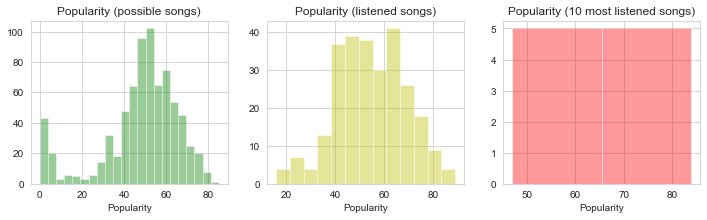

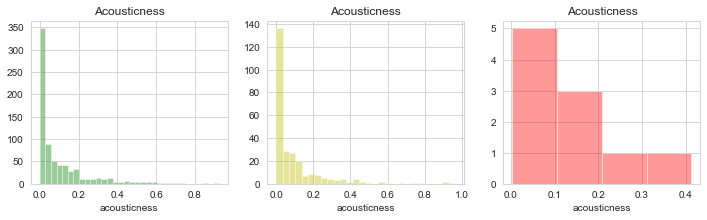

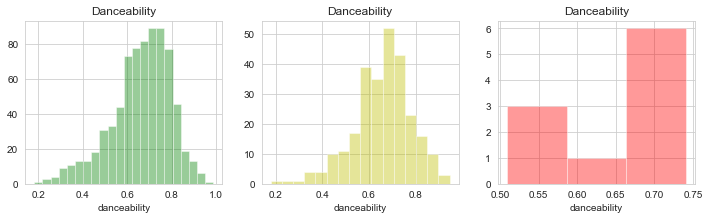

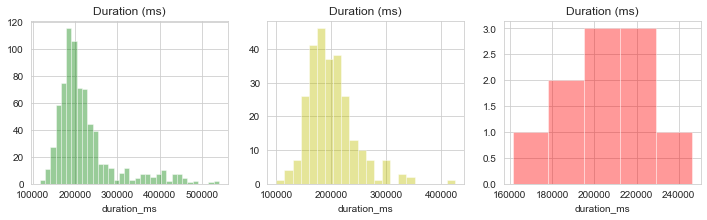

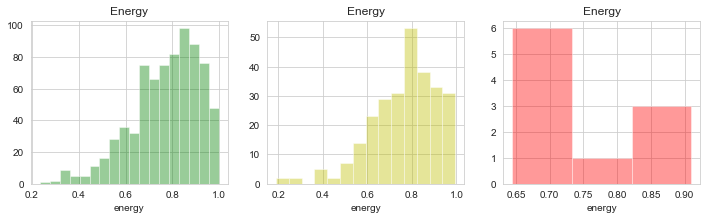

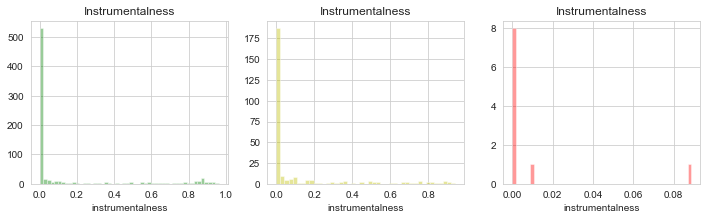

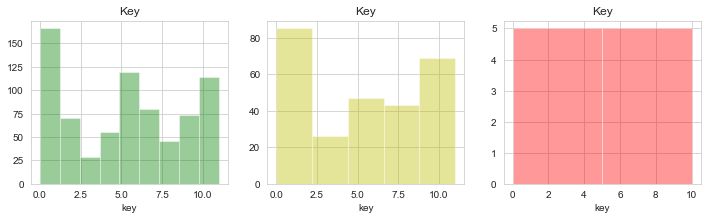

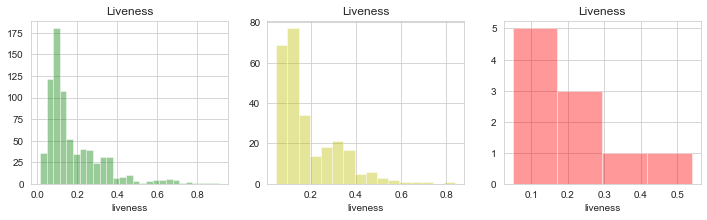

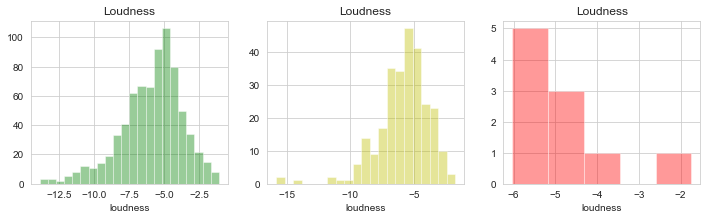

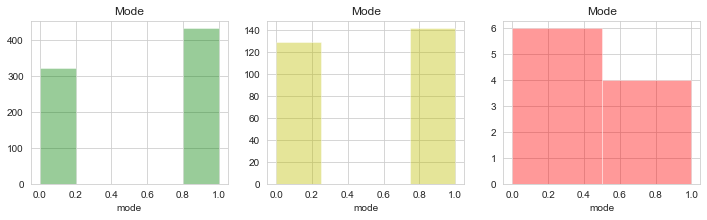

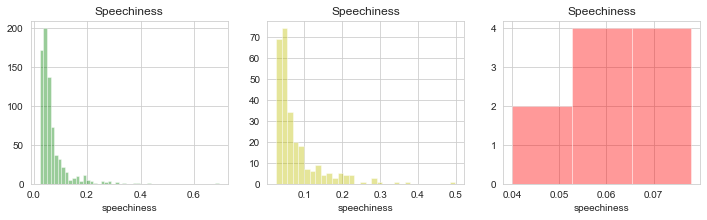

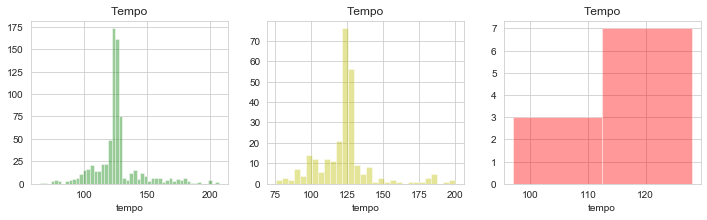

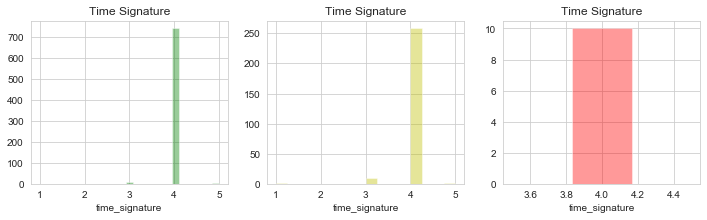

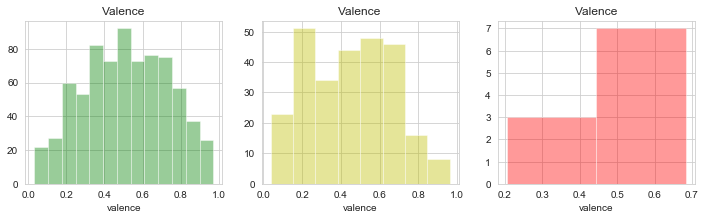

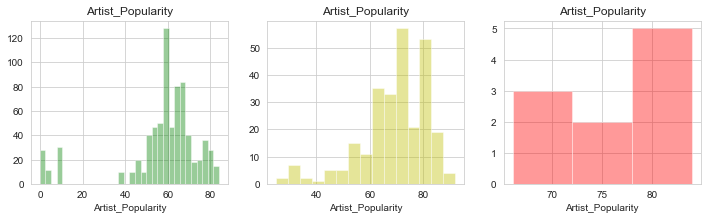

In [37]:
# Feature Statistics
fig, ax = plt.subplots(1,3,figsize=(12,3))
sns.distplot(potential_songs["Popularity"], color="g", ax=ax[0], kde=False).set_title("Popularity (possible songs)")
sns.distplot(listened_features["Popularity"], color="y", ax=ax[1], kde=False).set_title("Popularity (listened songs)")
sns.distplot(most_listened_songs["Popularity"], color="r", ax=ax[2], kde=False).set_title("Popularity (10 most listened songs)")
plt.show()

fig, ax = plt.subplots(1,3,figsize=(12,3))
sns.distplot(potential_songs["acousticness"], color="g", ax=ax[0], kde=False).set_title("Acousticness")
sns.distplot(listened_features["acousticness"], color="y", ax=ax[1], kde=False).set_title("Acousticness")
sns.distplot(most_listened_songs["acousticness"], color="r", ax=ax[2], kde=False).set_title("Acousticness")
plt.show()

fig, ax = plt.subplots(1,3,figsize=(12,3))
sns.distplot(potential_songs["danceability"], color="g", ax=ax[0], kde=False).set_title("Danceability")
sns.distplot(listened_features["danceability"], color="y", ax=ax[1], kde=False).set_title("Danceability")
sns.distplot(most_listened_songs["danceability"], color="r", ax=ax[2], kde=False).set_title("Danceability")
plt.show()

fig, ax = plt.subplots(1,3,figsize=(12,3))
sns.distplot(potential_songs["duration_ms"], color="g", ax=ax[0], kde=False).set_title("Duration (ms)")
sns.distplot(listened_features["duration_ms"], color="y", ax=ax[1], kde=False).set_title("Duration (ms)")
sns.distplot(most_listened_songs["duration_ms"], color="r", ax=ax[2], kde=False).set_title("Duration (ms)")
plt.show()

fig, ax = plt.subplots(1,3,figsize=(12,3))
sns.distplot(potential_songs["energy"], color="g", ax=ax[0], kde=False).set_title("Energy")
sns.distplot(listened_features["energy"], color="y", ax=ax[1], kde=False).set_title("Energy")
sns.distplot(most_listened_songs["energy"], color="r", ax=ax[2], kde=False).set_title("Energy")
plt.show()

fig, ax = plt.subplots(1,3,figsize=(12,3))
sns.distplot(potential_songs["instrumentalness"], color="g", ax=ax[0], kde=False).set_title("Instrumentalness")
sns.distplot(listened_features["instrumentalness"], color="y", ax=ax[1], kde=False).set_title("Instrumentalness")
sns.distplot(most_listened_songs["instrumentalness"], color="r", ax=ax[2], kde=False).set_title("Instrumentalness")
plt.show()

fig, ax = plt.subplots(1,3,figsize=(12,3))
sns.distplot(potential_songs["key"], color="g", ax=ax[0], kde=False).set_title("Key")
sns.distplot(listened_features["key"], color="y", ax=ax[1], kde=False).set_title("Key")
sns.distplot(most_listened_songs["key"], color="r", ax=ax[2], kde=False).set_title("Key")
plt.show()

fig, ax = plt.subplots(1,3,figsize=(12,3))
sns.distplot(potential_songs["liveness"], color="g", ax=ax[0], kde=False).set_title("Liveness")
sns.distplot(listened_features["liveness"], color="y", ax=ax[1], kde=False).set_title("Liveness")
sns.distplot(most_listened_songs["liveness"], color="r", ax=ax[2], kde=False).set_title("Liveness")
plt.show()

fig, ax = plt.subplots(1,3,figsize=(12,3))
sns.distplot(potential_songs["loudness"], color="g", ax=ax[0], kde=False).set_title("Loudness")
sns.distplot(listened_features["loudness"], color="y", ax=ax[1], kde=False).set_title("Loudness")
sns.distplot(most_listened_songs["loudness"], color="r", ax=ax[2], kde=False).set_title("Loudness")
plt.show()

fig, ax = plt.subplots(1,3,figsize=(12,3))
sns.distplot(potential_songs["mode"], color="g", ax=ax[0], kde=False).set_title("Mode")
sns.distplot(listened_features["mode"], color="y", ax=ax[1], kde=False).set_title("Mode")
sns.distplot(most_listened_songs["mode"], color="r", ax=ax[2], kde=False).set_title("Mode")
plt.show()

fig, ax = plt.subplots(1,3,figsize=(12,3))
sns.distplot(potential_songs["speechiness"], color="g", ax=ax[0], kde=False).set_title("Speechiness")
sns.distplot(listened_features["speechiness"], color="y", ax=ax[1], kde=False).set_title("Speechiness")
sns.distplot(most_listened_songs["speechiness"], color="r", ax=ax[2], kde=False).set_title("Speechiness")

fig, ax = plt.subplots(1,3,figsize=(12,3))
sns.distplot(potential_songs["tempo"], color="g", ax=ax[0], kde=False).set_title("Tempo")
sns.distplot(listened_features["tempo"], color="y", ax=ax[1], kde=False).set_title("Tempo")
sns.distplot(most_listened_songs["tempo"], color="r", ax=ax[2], kde=False).set_title("Tempo")
plt.show()

fig, ax = plt.subplots(1,3,figsize=(12,3))
sns.distplot(potential_songs["time_signature"], color="g", ax=ax[0], kde=False).set_title("Time Signature")
sns.distplot(listened_features["time_signature"], color="y", ax=ax[1], kde=False).set_title("Time Signature")
sns.distplot(most_listened_songs["time_signature"], color="r", ax=ax[2], kde=False).set_title("Time Signature")
plt.show()

fig, ax = plt.subplots(1,3,figsize=(12,3))
sns.distplot(potential_songs["valence"], color="g", ax=ax[0], kde=False).set_title("Valence")
sns.distplot(listened_features["valence"], color="y", ax=ax[1], kde=False).set_title("Valence")
sns.distplot(most_listened_songs["valence"], color="r", ax=ax[2], kde=False).set_title("Valence")
plt.show()

fig, ax = plt.subplots(1,3,figsize=(12,3))
sns.distplot(potential_songs["Artist_Popularity"], color="g", ax=ax[0], kde=False).set_title("Artist_Popularity")
sns.distplot(listened_features["Artist_Popularity"], color="y", ax=ax[1], kde=False).set_title("Artist_Popularity")
sns.distplot(most_listened_songs["Artist_Popularity"], color="r", ax=ax[2], kde=False).set_title("Artist_Popularity")
plt.show()

In [48]:
# Genres
genre_sum = genres(potential_songs, listened_features, most_listened_songs)

top_genres = genre_sum.sort_values(by="Top", ascending=False).loc[genre_sum["Top"] != 0]
genre_match_list = top_genres["Genre"][0:7].values.tolist() 


In [51]:
print("My most frequent listened genres, ordered by occurrence in most_listened_songs")
top_genres[0:7]

My most frequent listened genres, ordered by occurrence in most_listened_songs


,Genre,Potential,Listened,Top
0,edm,337,158,9
1,tropical house,310,116,8
6,dance pop,118,72,7
7,pop,117,89,7
4,pop edm,163,54,6
3,electro house,219,85,5
39,electropop,28,38,4


### 3.4 Feature Engineerning

In [52]:
listened_features = listened_features.reset_index(drop=True)

# top genre, my top 7 genres this week
listened_features["genre_match"] = 0
for k in range(len(listened_features)):   
    lista = listened_features["Genre"][k]
    if any(genre in lista for genre in genre_match_list):
        listened_features["genre_match"][k] = 1
        
potential_songs["genre_match"] = 0
for k in range(len(potential_songs)):
    if len(potential_songs["Genre"][k]) != 0:
        lista =  potential_songs["Genre"][k]
        if any(genre in lista for genre in genre_match_list):
            potential_songs["genre_match"][k] = 1


# top artist as a feature my top 10 most heavily listen artiist
listened_features["Top_artist"] = 0                    
top_artist_list = top_artists["Artist"].values.tolist()
for k in range(len(listened_features)):
    if any(artist == listened_features["Artist"][k] for artist in top_artist_list):
        listened_features["Top_artist"][k] = 1

potential_songs["Top_artist"] = 0                    
top_artist_list = top_artists["Artist"].values.tolist()
for k in range(len(potential_songs)):
    if any(artist == potential_songs["Artist"][k] for artist in top_artist_list):
        potential_songs["Top_artist"][k] = 1


listened_features = listened_features.sort_values(by="Plays", ascending=False)
listened_features["Top_Song"] = 0
listened_features["Top_Song"][0:10] = 1        
        
# save these for possible extension work
listened_features.to_csv(r"songs_features_week_32.csv")


### 3.5 Classification

In [112]:
from sklearn.preprocessing import MinMaxScaler 
from sklearn.decomposition import PCA

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier


from sklearn.metrics import accuracy_score ,roc_auc_score, f1_score, confusion_matrix


In [55]:
data = pd.read_csv("songs_features_week_32.csv")
data = data.drop(columns="Unnamed: 0")

# Dropping the least interesting columns and the ones that are completely arbitrary columnerna. Also dropping the top_artist column since it will have a too strong influence on the classification and lead to that only these songs get recommended
data = data.drop(columns=["Name","Id","key","mode","time_signature","Artist","Genre","Plays","Top_artist"], axis = 1)
data.shape

(270, 14)

(14.0, 0.0)

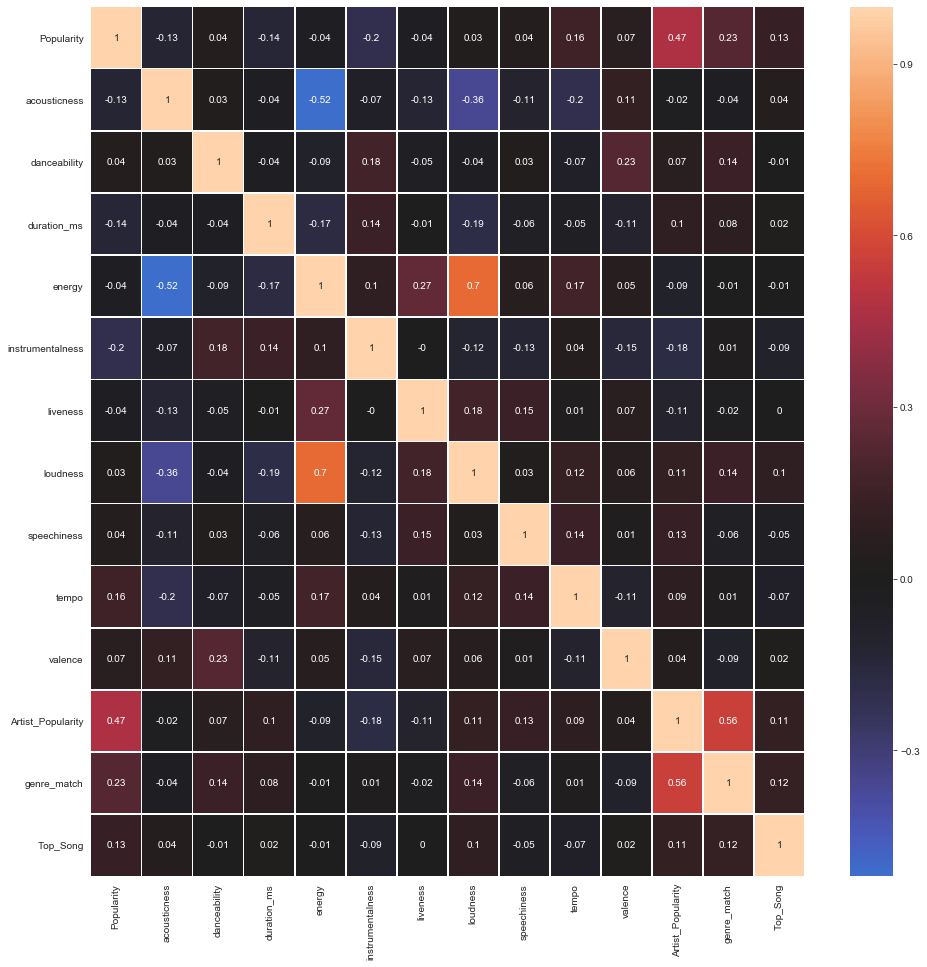

In [56]:
# Correlation matrix for feature selection
plt.figure(figsize=(16,16))
corr = sns.heatmap(np.round(data.corr(),2),annot=True, center=0,linewidths=.5)

# There are strange cut offs for the highest/lowest rows, fixed with the following 
bottom, top = corr.get_ylim()
corr.set_ylim(bottom + 0.5, top - 0.5)

In [57]:
# In preperation for the models I scale all variables
scaler = MinMaxScaler()

data_scaled = pd.DataFrame(scaler.fit_transform(data),columns = data.columns)

data_scaled_x = data_scaled.drop(columns=["Top_Song"])

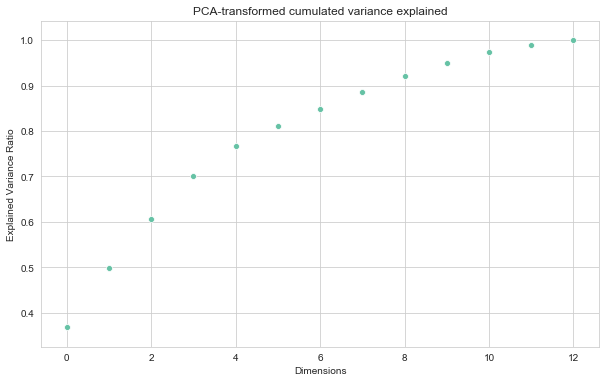

In [58]:
# In trying to reduce complexity of the models I want to use fewer variables. By constructing PCAs I want to see how much of the varience is explained by variables used.  
pca=PCA()

pca.fit(data_scaled_x)
data_pca=pca.transform(data_scaled_x)
el=np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
ax = sns.scatterplot(data=el,color=sns.color_palette("Set2")[0])
ax.set(xlabel='Dimensions', ylabel='Explained Variance Ratio')
plt.title("PCA-transformed cumulated variance explained")
plt.show()


It turns out we want to use as many columns as possible. My initial idea was to choose the five or so variables with the highest correlation with "Top_Song" but that would give a less clear picture. Also all varibales have quite similar magnitude of correlation so the decion of which to choose could easily become misleading.


In [59]:
# Unbalanced dataset

data_y = data_scaled["Top_Song"]
data_y.value_counts()

0.0    260
1.0     10
Name: Top_Song, dtype: int64

In [60]:
# This would create problems for the fitting of the prediction model. Becouse of this I'm oversampling the Top Songs using SMOTE 
oversample = SMOTE()
smote_x, smote_y = oversample.fit_resample(data_scaled_x, data_y)


In [61]:
# Splitting the dataset into 70/30 train/validation set
x_train_70, x_test_30, y_train_70, y_test_30 = train_test_split(smote_x, smote_y, test_size = 0.30, random_state = 42)


**Random Forrest**

In [62]:
# Hyperparameter tuning for RandomForest
# Create a parameter grid to sample from during fitting

# Parameters:

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


In [63]:
# Use the random grid to narrow down the possible best hyperparameters
rf = RandomForestClassifier()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(x_train_70, y_train_70)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   34.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.2min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [64]:
# Found best parameters
rf_random.best_params_


{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 20,
 'bootstrap': True}

In [65]:
# Find the specific best parameters by searching every combination close to our earlier findings

# Create a new parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [10,20,30],
    'max_features': [2, 3],
    'min_samples_leaf': [1, 2],
    'min_samples_split': [1, 2, 3],
    'n_estimators': [800, 1000, 1200]
}

# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(x_train_70, y_train_70)

grid_search.best_params_


Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed:  3.5min finished


{'bootstrap': True,
 'max_depth': 10,
 'max_features': 2,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 800}

Random Forest Model Validation result:

Accuracy Score: 0.9871794871794872

 F1 Score: 0.9875
 
 AUC Score: 0.987012987012987


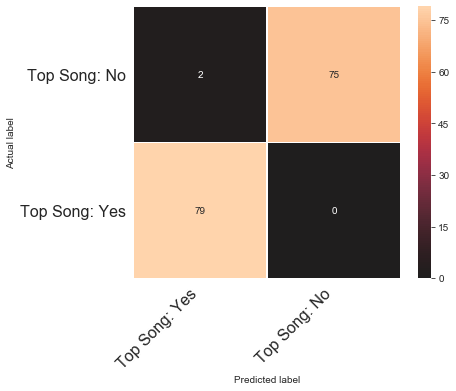

In [109]:
# Validation of RF 
# Using F1, accuracy, and AUC

rf_best = RandomForestClassifier(n_estimators = 800, min_samples_split = 2,
                                 min_samples_leaf = 1, max_features = 2,
                                 max_depth = 10, bootstrap = False)

rf_best.fit(x_train_70, y_train_70)
rf_pred_30_best = rf_best.predict(x_test_30)

print('Random Forest Model Validation result:\n')
print_confusion_matrix(confusion_matrix(y_test_30,rf_pred_30_best,labels=[1,0]),["Top Song: Yes","Top Song: No"])
print('Accuracy Score: {}\n\n F1 Score: {}\n \n AUC Score: {}'
      .format(accuracy_score(y_test_30,rf_pred_30_best), f1_score(y_test_30,rf_pred_30_best), roc_auc_score(y_test_30,rf_pred_30_best)))


Base Random Forest Model Validation result:

Accuracy Score: 0.9871794871794872

 F1 Score: 0.9875
 
 AUC Score: 0.987012987012987


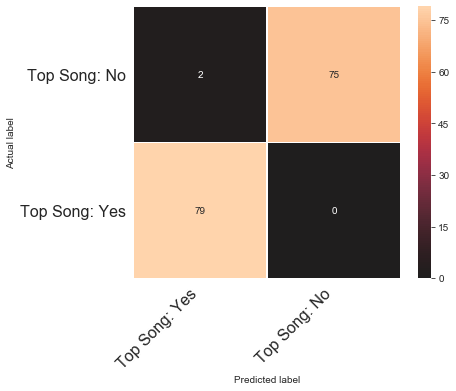

In [110]:
# Comparison with the base classifier
rf_base = RandomForestClassifier()


rf_base.fit(x_train_70, y_train_70)
rf_pred_30_base = rf_base.predict(x_test_30)

print('Base Random Forest Model Validation result:\n')
print_confusion_matrix(confusion_matrix(y_test_30,rf_pred_30_base,labels=[1,0]),["Top Song: Yes","Top Song: No"])
print('Accuracy Score: {}\n\n F1 Score: {}\n \n AUC Score: {}'
      .format(accuracy_score(y_test_30,rf_pred_30_base), f1_score(y_test_30,rf_pred_30_base), roc_auc_score(y_test_30,rf_pred_30_base)))

The base model turns out to be as good as the optimized model. Somewhat unfortunate the optimization didn't have an impact but at the same time they recive very good scores. In prior weeks I have observed similarly very good scores of the base model but always a small improvement in the optimized. 

**K-Nearest Neighbor**

In [116]:
# Hyperparameter tuning

# Number of neighbors k
n_neighbors = list(range(1,30))

# Leaf size
leaf_size = list(range(1,50))

# Power of for calculating the Minkowski distance
p = list(range(1,4))

random_grid = {
    "n_neighbors": n_neighbors,
    "leaf_size": leaf_size,
    "p": p
}


knn = KNeighborsClassifier()

knn_random = RandomizedSearchCV(estimator = knn, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

knn_random.fit(x_train_70, y_train_70)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 293 out of 300 | elapsed:    4.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    4.2s finished


RandomizedSearchCV(cv=3, estimator=KNeighborsClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'leaf_size': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19, 20, 21,
                                                      22, 23, 24, 25, 26, 27,
                                                      28, 29, 30, ...],
                                        'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8,
                                                        9, 10, 11, 12, 13, 14,
                                                        15, 16, 17, 18, 19, 20,
                                                        21, 22, 23, 24, 25, 26,
                                                        27, 28, 29],
                                        'p': [1, 2, 3]},
                   random_state=42, verbose=2)

In [118]:
knn_random.best_params_

{'p': 1, 'n_neighbors': 2, 'leaf_size': 29}

In [119]:
# Create a new parameter grid based on the results of random search 

param_grid = {
    "n_neighbors": [1,2,3,4,5],
    "leaf_size": [27,28,29,30,31],
    "p": [1,2]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = knn, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(x_train_70, y_train_70)

grid_search.best_params_

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    5.7s finished


{'leaf_size': 27, 'n_neighbors': 2, 'p': 1}

Random Forest Model Validation result:

Accuracy Score: 0.9487179487179487

 F1 Score: 0.9518072289156626
 
 AUC Score: 0.948051948051948


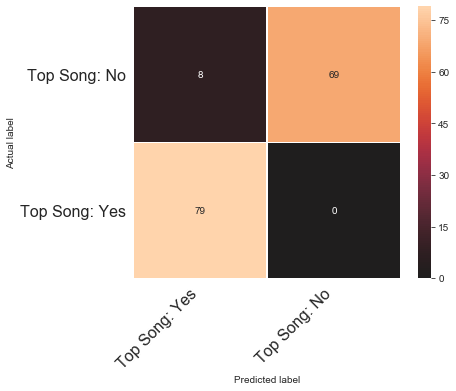

In [121]:
# Validation of KNN 

knn_best = KNeighborsClassifier(leaf_size = 27, n_neighbors = 2, p = 1)

knn_best.fit(x_train_70, y_train_70)
knn_pred_30_best = knn_best.predict(x_test_30)

print('Random Forest Model Validation result:\n')
print_confusion_matrix(confusion_matrix(y_test_30,knn_pred_30_best,labels=[1,0]),["Top Song: Yes","Top Song: No"])
print('Accuracy Score: {}\n\n F1 Score: {}\n \n AUC Score: {}'
      .format(accuracy_score(y_test_30,knn_pred_30_best), f1_score(y_test_30,knn_pred_30_best), roc_auc_score(y_test_30,knn_pred_30_best)))


Base Random Forest Model Validation result:

Accuracy Score: 0.8525641025641025

 F1 Score: 0.8729281767955802
 
 AUC Score: 0.8506493506493507


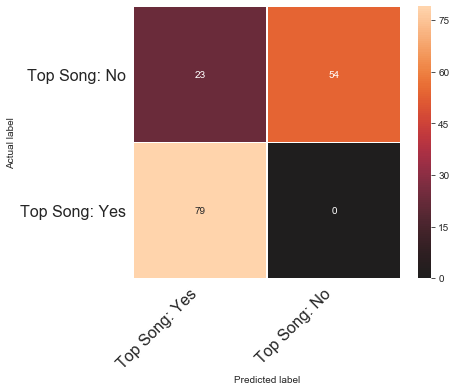

In [122]:
# Comparison with the base classifier
knn_base = KNeighborsClassifier()

knn_base.fit(x_train_70, y_train_70)
knn_pred_30_base = knn_base.predict(x_test_30)

print('Base Random Forest Model Validation result:\n')
print_confusion_matrix(confusion_matrix(y_test_30,knn_pred_30_base,labels=[1,0]),["Top Song: Yes","Top Song: No"])
print('Accuracy Score: {}\n\n F1 Score: {}\n \n AUC Score: {}'
      .format(accuracy_score(y_test_30,knn_pred_30_base), f1_score(y_test_30,knn_pred_30_base), roc_auc_score(y_test_30,knn_pred_30_base)))

The random forest have the by far best results, therefore I choose it as my classifer for recommending songs.

In [123]:
X_test = potential_songs.drop(columns=['Name', 'Id',
       'key','mode', 'time_signature',"Genre","Artist","Top_artist"]).astype(float)
    
X_test = pd.DataFrame(scaler.fit_transform(X_test),columns = X_test.columns)

Y_pred_RF = rf_best.predict(X_test)


recommended_songs = pd.DataFrame(index=potential_songs.index)
recommended_songs["Name"] = potential_songs["Name"]
recommended_songs["id"] = potential_songs["Id"]
recommended_songs["Artist"] = potential_songs["Artist"]
recommended_songs["RF_rec"] = Y_pred_RF
recommended_songs = recommended_songs[recommended_songs.RF_rec != 0]
recommended_songs = recommended_songs.reset_index(drop=True)
recommended_songs = recommended_songs.drop(columns=["RF_rec"])
recommended_songs

,Name,id,Artist
0,Bloodshot,0RjsxObqclok5pyah4SPoh,Mike Perry
1,Somebody,6iMoJ3UdrO2ZjzzcaN8Eom,Sigala
2,Nobody Compares To You (feat. Katie Pearlman),17ejRbr6B8l9zdqgCZsn4m,Gryffin
3,Just Friends,3NjyrsDr4qS0L424H4muQd,Hayden James
4,How Deep Is Your Love,22mek4IiqubGD9ctzxc69s,Disciples
5,This Ole Boy,29rfPTA47K0xyl1Pnf1YBw,Craig Morgan


In [124]:
# To CSV for possible future work, overall I'm quite happy with these recomendations
recommended_songs.to_csv(r'reco_week32.csv')
